# Red neuronal densa: Classification

We now consider a densely connected neural network (DNN) applied to a binary classification problem. We will consider the room occupancy dataset in the Kaggle repository:

https://www.kaggle.com/sachinsharma1123/room-occupancy/version/1

In [ ]:
# data analytics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Keras
from keras.models import Sequential
from keras.layers import Dense

# Sklearn
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
# mount to Google Drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**1. Dataset exploration**

In [ ]:
# load data
df = pd.read_csv('rooms.csv')

In [ ]:
# dataset exploration
df.head(10)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.7000,26.272,585.200000,749.200000,0.004764,1
1,23.7180,26.290,578.400000,760.400000,0.004773,1
2,23.7300,26.230,572.666667,769.666667,0.004765,1
3,23.7225,26.125,493.750000,774.750000,0.004744,1
4,23.7540,26.200,488.600000,779.000000,0.004767,1
5,23.7600,26.260,568.666667,790.000000,0.004779,1
6,23.7300,26.290,536.333333,798.000000,0.004776,1
7,23.7540,26.290,509.000000,797.000000,0.004783,1
8,23.7540,26.350,476.000000,803.200000,0.004794,1
9,23.7360,26.390,510.000000,809.000000,0.004796,1


In [ ]:
# dataset size
df.shape

(2665, 6)

In [ ]:
# dataset statistics
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
mean,21.433876,25.353937,193.227556,717.906470,0.004027,0.364728
std,1.028024,2.436842,250.210906,292.681718,0.000611,0.481444
min,20.200000,22.100000,0.000000,427.500000,0.003303,0.000000
25%,20.650000,23.260000,0.000000,466.000000,0.003529,0.000000
50%,20.890000,25.000000,0.000000,580.500000,0.003815,0.000000
75%,22.356667,26.856667,442.500000,956.333333,0.004532,1.000000
max,24.408333,31.472500,1697.250000,1402.250000,0.005378,1.000000


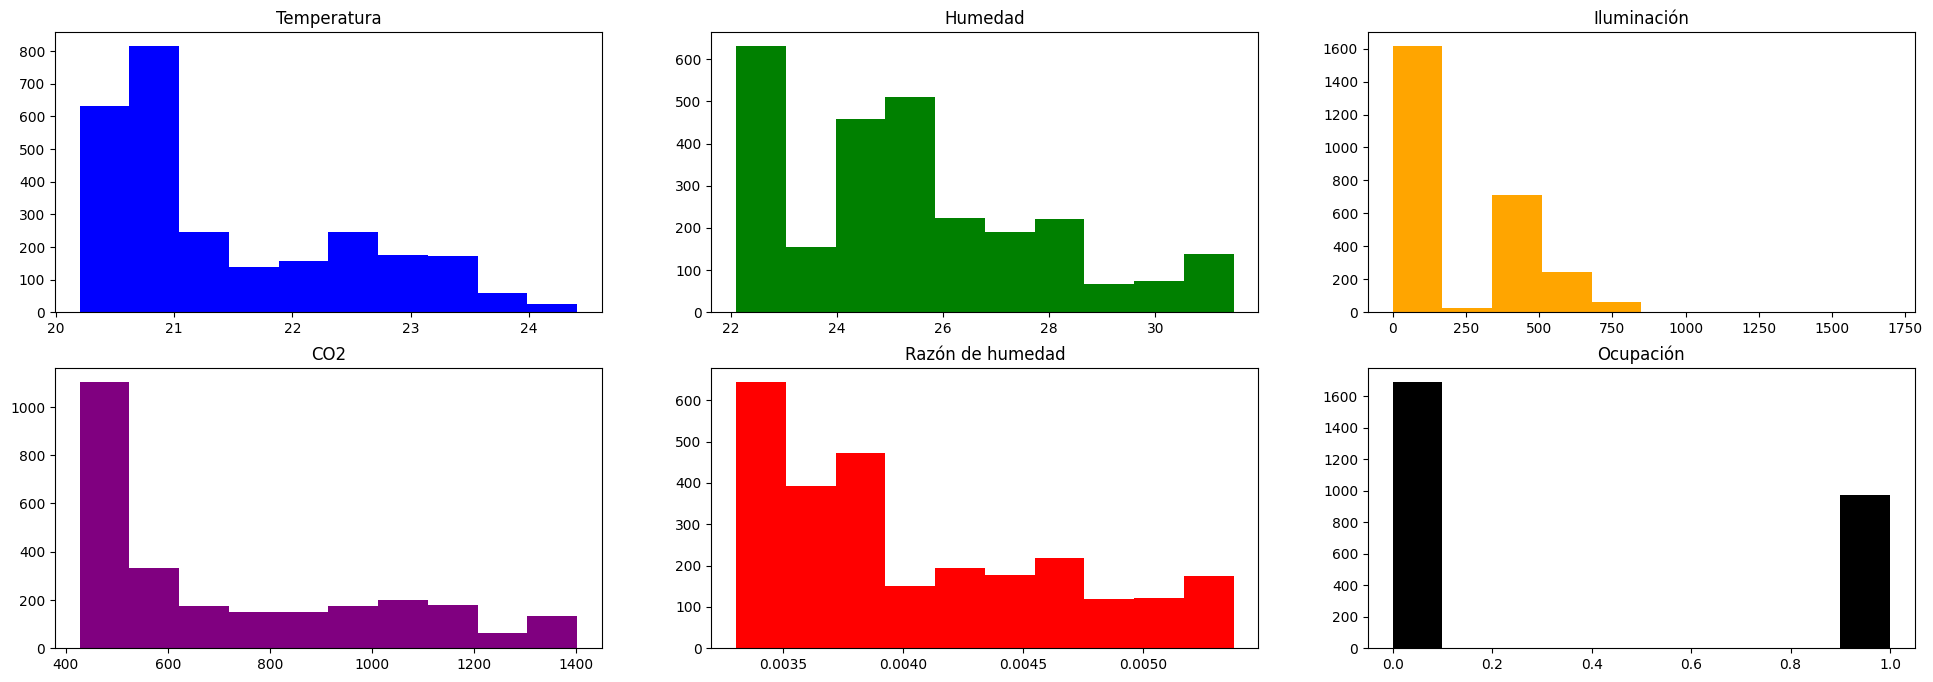

In [ ]:
# dataset visualization
fig, ax = plt.subplots(2,3)
fig.set_figwidth(24)
fig.set_figheight(8)

x = ax[0,0].hist(df['Temperature'], bins=10, color='blue')
ax[0,0].title.set_text('Temperature')

x = ax[0,1].hist(df['Humidity'], bins=10, color='green')
ax[0,1].title.set_text('Humidity')

x = ax[0,2].hist(df['Light'], color='orange')
ax[0,2].title.set_text('Light')

x = ax[1,0].hist(df['CO2'], bins=10, color='purple')
ax[1,0].title.set_text('CO2')

x = ax[1,1].hist(df['HumidityRatio'], bins=10, color='red')
ax[1,1].title.set_text('Humidity Ratio')

x = ax[1,2].hist(df['Occupancy'], color='black')
ax[1,2].title.set_text('Occupancy')

<Axes: >

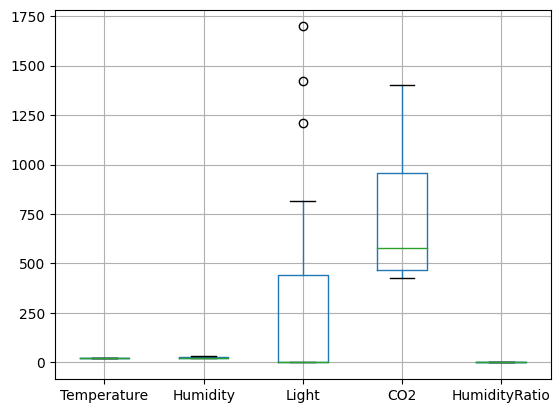

In [ ]:
# outliers
df.boxplot(column=['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'])

<Axes: >

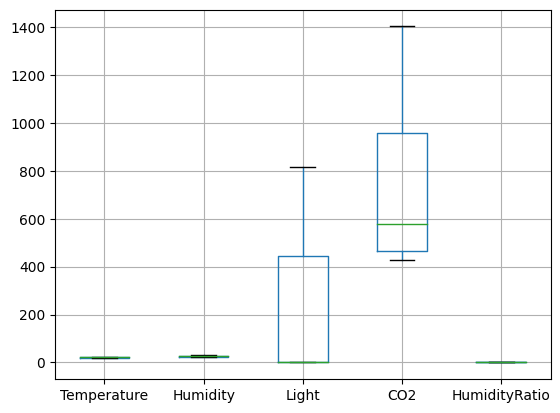

In [ ]:
# outlier removal
Q1, Q3 = df['Light'].quantile(0.25), df['Light'].quantile(0.75)
IQR = Q3 - Q1
max = Q3 + 1.5*IQR
df = df.drop(df[df['Light'] > max].index, axis=0)

df.boxplot(column=['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'])

Since we have a binary classification problem, we must encode the output so that we only have values ​​of 0 and 1.

In [ ]:
df['Occupancy'].unique()

array([1, 0])

If it is not encoded, we can use an encoding such as Label Encoding.

In [ ]:
# codificación de respuesta
# enc = LabelEncoder()
# df[target] = enc.fit_transform(df[target])

**2. Model construction**

Having loaded and prepared the data, we will proceed to build a base model for the DNN neural network.

In [ ]:
# training features
X = df[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']]
y = df[['Occupancy']] # variable objectivo

# dataset splitting
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, random_state=81)

In [ ]:
X_train.shape, X_test.shape

((1996, 5), (666, 5))

We scale the input variables to have better performance of the neural network (and avoid saturation of the output activation function).

In [ ]:
# we apply a logarithmic transformation
def log_transf(df):
  df = df.replace(0.0,1.0)
  cols = df.columns
  for col in cols:
    df[col] = np.log(df[col])

  return df.fillna(0.0)

X_train = log_transf(X_train)
X_test = log_transf(X_test)

In [ ]:
X_train

,Temperature,Humidity,Light,CO2,HumidityRatio
1987,3.039271,3.222868,0.000000,6.333724,-5.564780
676,3.025291,3.095578,0.000000,6.102559,-5.710762
846,3.015045,3.112292,0.000000,6.081077,-5.706986
2410,3.025291,3.182212,0.000000,6.147934,-5.623647
1850,3.049273,3.277145,0.000000,6.476203,-5.497166
...,...,...,...,...,...
1713,3.081451,3.363496,0.000000,6.896694,-5.367642
1009,3.005683,3.126322,0.000000,6.074196,-5.704687
75,3.144152,3.347005,6.139885,7.014590,-5.297914
942,3.009241,3.121483,0.000000,6.079933,-5.705076


In [ ]:
X.shape[1]

5

In [ ]:
# baseline model
def baseline_model(X):

	# we declare a sequential model
	model = Sequential()

	# we add the hidden layer (we must indicate the dimension of the input data)
	model.add(Dense(10, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))

	# we add the output layer (a node since it is binary classification)
	model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

	# if you had more than 2 classes, e.g., 10 classes
	# model.add(Dense(10, ...))

	# compilamos el modelo
	model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

	return model

In [ ]:
# we create an object for the model
model = baseline_model(X_train)

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 71 (284.00 Byte)
Trainable params: 71 (284.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We have 5 inputs + 1 bias, so there are 6 input weights. If we have 10 nodes in the hidden layer, then 6x10=60 weights to train for the hidden layer.
For the output layer we have 10 inputs (coming from the hidden layer) + 1 bias, that is, 11 weights from the hidden to the output. If the output layer has 1 node, then 11x1=11 weights to train the output layer.

In [ ]:
# train neural network
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, validation_data=(X_test, y_test))

Epoch 1/100
32/32 [==============================] - 3s 12ms/step - loss: 0.6892 - accuracy: 0.6398 - val_loss: 0.6821 - val_accuracy: 0.6171
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6708 - accuracy: 0.6423 - val_loss: 0.6565 - val_accuracy: 0.6171
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6338 - accuracy: 0.6473 - val_loss: 0.6106 - val_accuracy: 0.6471
Epoch 4/100
32/32 [==============================] - 0s 4ms/step - loss: 0.5790 - accuracy: 0.8302 - val_loss: 0.5505 - val_accuracy: 0.9805
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.5134 - accuracy: 0.9795 - val_loss: 0.4827 - val_accuracy: 0.9805
Epoch 6/100
32/32 [==============================] - 0s 4ms/step - loss: 0.4446 - accuracy: 0.9719 - val_loss: 0.4137 - val_accuracy: 0.9715
Epoch 7/100
32/32 [==============================] - 0s 5ms/step - loss: 0.3782 - accuracy: 0.9709 - val_loss: 0.3489 - val_accuracy: 0.9715
Epoch 8/100


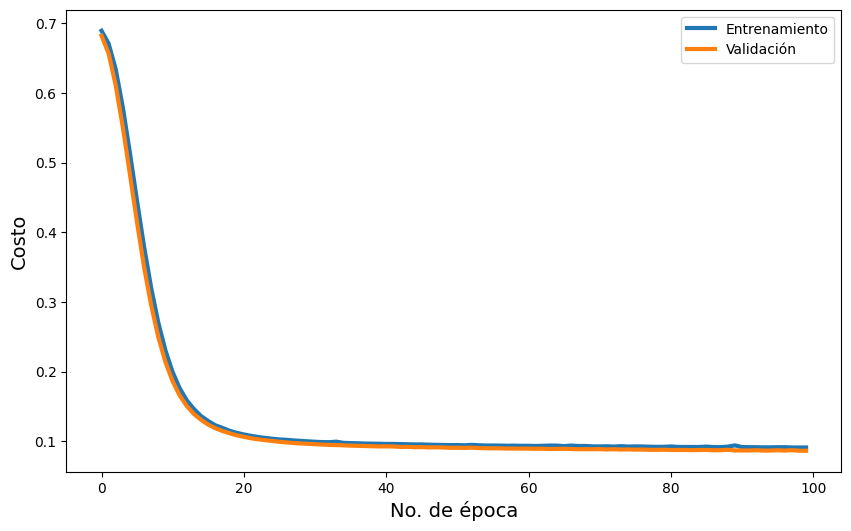

In [ ]:
# cost function display (binary crossentropy)
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], linestyle='-', linewidth=3.0, label='Entrenamiento')
plt.plot(history.history['val_loss'], linestyle='-', linewidth=3.0, label='Validación')

plt.xlabel('No. de época', fontsize=14)
plt.ylabel('Costo', fontsize=14)
plt.legend()

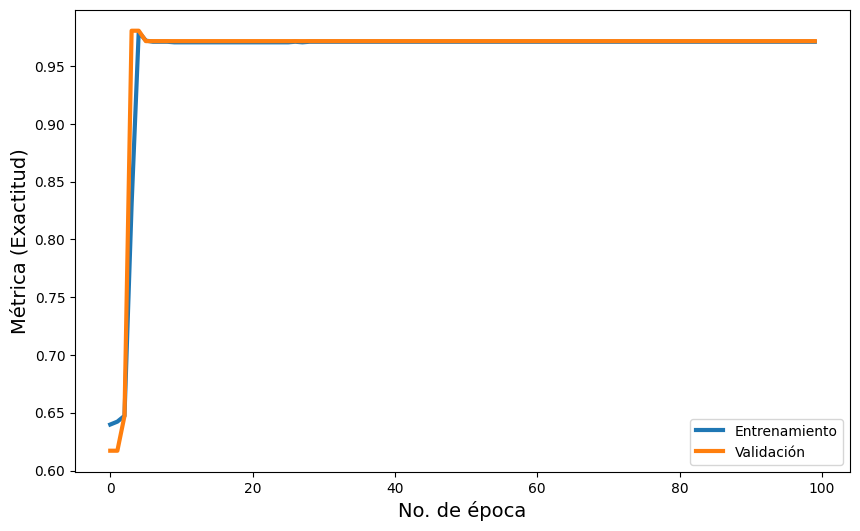

In [ ]:
# visualization of accuracy
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], linestyle='-', linewidth=3.0, label='Entrenamiento')
plt.plot(history.history['val_accuracy'], linestyle='-', linewidth=3.0, label='Validación')

plt.xlabel('Epoch Number', fontsize=14)
plt.ylabel('Metric (Accuracy)', fontsize=14)
plt.legend()

Another way to measure the performance of the model is to consider the **confusion matrix** of the classifier.

In [ ]:
# encode predictions a binary
def get_preds(x):
  y = []
  for i in range(len(x)):
    if x[i] < 0.5:
      y.append(0)
    else:
      y.append(1)

  return np.array(y)

y_obs = np.array(y_test.values).flatten()
y_pred = get_preds(model.predict(X_test))

# confusion matrix
cm = confusion_matrix(y_obs, y_pred)
print('==Matriz de confusion==')
print(cm)
print('')

# classification metrics
tp, tn, fp, fn = cm[0,0], cm[1,1], cm[1,0], cm[0,1]
accuracy, precision, recall = (tp+tn)/(tp+tn+fp+fn), tp/(tp+fp), tp/(tp+fn)
f1 = 2*(precision*recall)/(precision+recall)
print('Accuracy:', round(accuracy,2))
print('Precision', round(precision,2))
print('Recall:', round(recall,2))
print('F1:', round(f1, 2))

21/21 [==============================] - 0s 2ms/step
==Matriz de confusion==
[[392  19]
 [  0 255]]

Accuracy: 0.97
Precision 1.0
Recall: 0.95
F1: 0.98


**3. Cross validation**

In [ ]:
# we define the k-folds for validation
kf = KFold(n_splits=3, random_state=0, shuffle=True)
i = 1

val_loss_kfold, val_acc_kfold = [], []

for train_index, test_index in kf.split(X):
  print('K-Fold #'+str(i)+' ...')
  # K-fold separation
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # data standardization
  X_train = log_transf(X_train)
  X_test = log_transf(X_test)

  # model training
  history = model.fit(X_train, y_train, epochs=50, batch_size=128, verbose=0)

  # model evaluation
  val_loss, val_acc = model.evaluate(X_test, y_test, verbose=1)

  val_loss_kfold.append(val_loss)
  val_acc_kfold.append(val_acc)

  i += 1

print('')
print('Costo:', val_loss_kfold)
print('Exactitud:', val_acc_kfold)

K-Fold #1 ...
28/28 [==============================] - 0s 2ms/step - loss: 0.0784 - accuracy: 0.9741
K-Fold #2 ...
28/28 [==============================] - 0s 6ms/step - loss: 0.0892 - accuracy: 0.9707
K-Fold #3 ...
28/28 [==============================] - 0s 6ms/step - loss: 0.0945 - accuracy: 0.9684

Costo: [0.07839728146791458, 0.08922117948532104, 0.09452851116657257]
Exactitud: [0.9740990996360779, 0.9706876873970032, 0.9684329032897949]


In [ ]:
print('Cost (Average): {}'.format(round(np.mean(val_loss_kfold),4)))
print('Accuracy (Average): {}'.format(round(np.mean(val_acc_kfold),4)))

Costo Promedio: 0.0874
Exactitud Promedio: 0.9711
